In [1]:
import tensorflow as tf
import tensorflow.keras.layers as tfkl
import numpy as np
import matplotlib.pyplot as plt

## Generate dataset
- y = x^3 + e, e ~ N(0, 3^2)

In [2]:
np.random.seed(7)
sig = 3

n = 20
x_data = 8 * np.random.random(size=n) - 4
e = sig * np.random.randn(n)

yfun = lambda x: x**3 + sig * np.random.randn()
y_data = map(yfun, x_data)

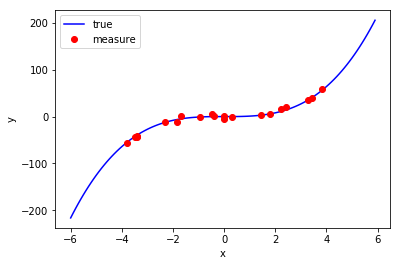

In [3]:
_x = np.arange(-6, 6, 0.1)
_y = map(lambda x: x*x*x, _x)
plt.plot(_x, _y, 'b-', label='true')
plt.plot(x_data, y_data, 'ro', label='measure')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

In [4]:
def normalize_data(x):
    mu = np.mean(x)
    std = np.std(x)
    return (x-mu)/std, mu, std

In [5]:
x_data_norm, x_mu, x_std = normalize_data(x_data)
y_data_norm, y_mu, y_std = normalize_data(y_data)

In [6]:
dataset = tf.data.Dataset.from_tensor_slices({
    'x': np.array(x_data_norm).astype(np.float32),
    'y': np.array(y_data_norm).astype(np.float32)
})
dataset = dataset.shuffle(20).batch(5)

## Regression Model

In [7]:
class Regressor(tf.keras.Model):
    def __init__(self, dense=50):
        super(Regressor, self).__init__()
        
        self.dense1 = tfkl.Dense(
            dense, activation=tf.nn.relu, bias_initializer='glorot_normal')
        
        self.dense2 = tfkl.Dense(
            dense, activation=tf.nn.relu, bias_initializer='glorot_normal')
        
        self.ff = tfkl.Dense(2, bias_initializer='glorot_normal')
        
    def call(self, x):
        out = self.dense1(x)
        out = self.dense2(out)
        out = self.ff(out)
        
        mean, raw_var = tf.split(out, num_or_size_splits=2, axis=1)
        
        var = tf.math.log(1.0 + tf.exp(raw_var)) + 1e-6
        return mean, var

In [9]:
def gaussian_nll(mean_values, var_values, y):
    y_diff = tf.math.subtract(y, mean_values)
    return 0.5*tf.reduce_mean(tf.math.log(var_values)) \
            + 0.5*tf.reduce_mean(tf.divide(tf.square(y_diff), var_values)) \
            + 0.5*tf.math.log(2*np.pi)

In [10]:
def grad(model, inputs, outputs):
    with tf.GradientTape() as t:
        mean_values, var_values = model(inputs)
        current_loss = gaussian_nll(mean_values, var_values, outputs)
    grads = t.gradient(current_loss, model.trainable_variables)
    
    return current_loss, grads

In [11]:
ensemble = [Regressor(50) for _ in range(5)]

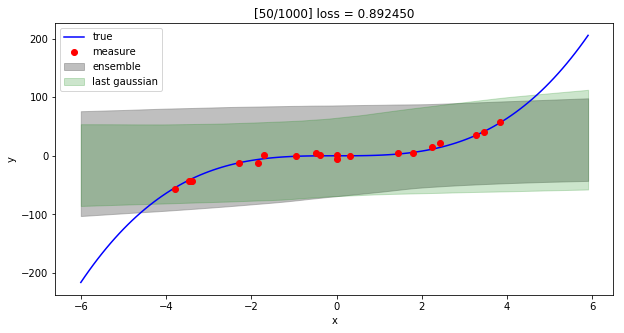

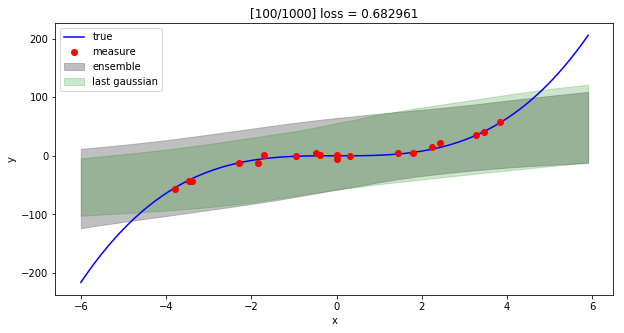

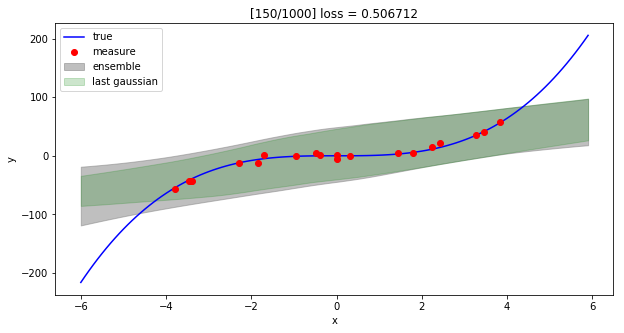

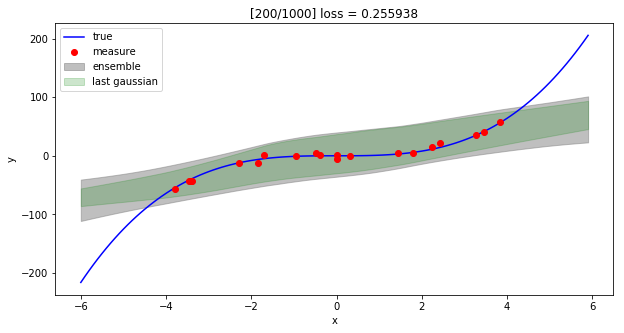

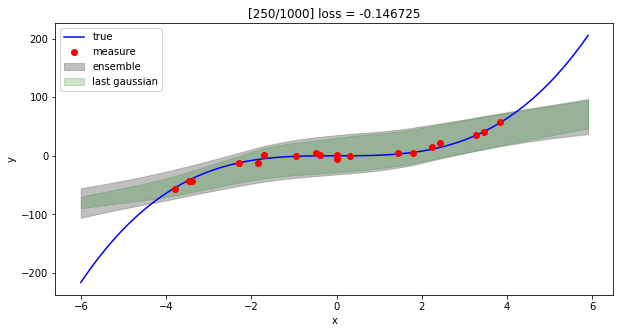

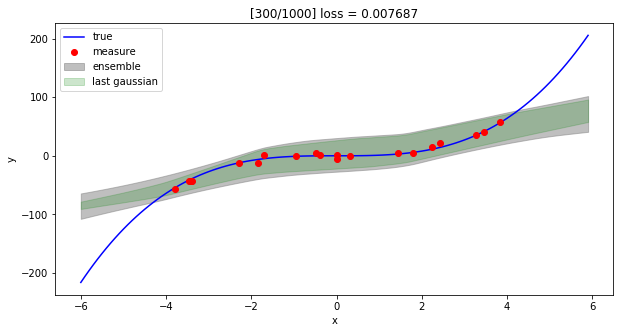

In [ ]:
EPOCHS = 1000
model_index = -1
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005, clipvalue=10.)
for epoch in range(1, EPOCHS+1):
    for data in dataset:
        x, y = data['x'], data['y']
        x = tf.expand_dims(x, 1)
        y = tf.expand_dims(y, 1)
        
        model_index = (model_index + 1) % len(ensemble)
        model = ensemble[model_index]
    
        with tf.GradientTape() as t:
            t.watch(x)
            loss_val, grads = grad(model, x, y)
        xgrad = t.gradient(loss_val, x)
    #     print(xgrad)
        x_p = x + 0.01 * tf.sign(xgrad)
        _, grads_adversarial = grad(model, x_p, y)

        alpha = 0.5
#         grads = grads + [alpha*_g for _g in grads_adversarial]
        grads = grads + grads_adversarial
        
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
    if epoch % 50 == 0:
        _x = np.arange(-6, 6, 0.1)
        _y = map(lambda x: x*x*x, _x)

        plt.figure(figsize=(10,5))
        plt.title('[{}/{}] loss = {:5f}'.format(epoch, EPOCHS, loss_val))
        plt.plot(_x, _y, 'b-', label='true')
        plt.plot(x_data, y_data, 'ro', label='measure')

        mu_list = []
        var_list = []
        for model in ensemble:
            mu, var = model.predict((_x - x_mu)/x_std)
            mu = np.squeeze(mu)
            var = np.squeeze(var)
            mu_list.append(mu)
            var_list.append(var)

        mu_star = np.mean(np.array(mu_list), axis=0)
        var_star = np.mean(np.array(var_list) + np.array(mu_list) ** 2, axis=0) - mu_star ** 2

        upper_y = np.squeeze(mu_star + 3*np.sqrt(var_star))*y_std + y_mu
        lower_y = np.squeeze(mu_star - 3*np.sqrt(var_star))*y_std + y_mu

        plt.fill_between(_x, lower_y, upper_y, color='gray', alpha=0.5, label='ensemble')

        upper_y = np.squeeze(mu + 3*np.sqrt(var))*y_std + y_mu
        lower_y = np.squeeze(mu - 3*np.sqrt(var))*y_std + y_mu

        plt.fill_between(_x, lower_y, upper_y, color='green', alpha=0.2, label='last gaussian')
        plt.xlabel('x')
        plt.ylabel('y')
        plt.legend()
        plt.show()

In [ ]:
for i, _var in enumerate(var_list):
    plt.plot(_x, np.sqrt(_var), label='std {}'.format(i))
plt.legend()

In [ ]:
_x = np.arange(-6, 6, 0.1)
_y = map(lambda x: x*x*x, _x)

plt.figure(figsize=(10,5))
plt.plot(_x, _y, 'b-', label='true')
plt.plot(x_data, y_data, 'ro', label='measure')

mu_list = []
var_list = []
for model in ensemble:
    mu, var = model.predict((_x - x_mu)/x_std)
    mu = np.squeeze(mu)
    var = np.squeeze(var)
    mu_list.append(mu)
    var_list.append(var)

mu_star = np.mean(np.array(mu_list), axis=0)
var_star = np.mean(np.array(var_list) + np.array(mu_list) ** 2, axis=0) - mu_star ** 2
    
upper_y = np.squeeze((mu_star + 3*np.sqrt(var_star))*y_std + y_mu)
lower_y = np.squeeze((mu_star - 3*np.sqrt(var_star))*y_std + y_mu)

plt.fill_between(_x, lower_y, upper_y, color='gray', alpha=0.5, label='ensemble')

upper_y = np.squeeze((mu + 3*np.sqrt(var))*y_std + y_mu)
lower_y = np.squeeze((mu - 3*np.sqrt(var))*y_std + y_mu)

plt.fill_between(_x, lower_y, upper_y, color='green', alpha=0.2, label='last gaussian')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

In [ ]:
var

In [ ]:
a = np.array([1,2,3])

In [ ]:
a ** 2

In [ ]:
np.mean(np.array(mu_list), axis=0).shape

In [ ]:
var.shape